## <center>Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split,RandomizedSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_sample_weight
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from prettytable import PrettyTable
from prettytable import ALL, FRAME

In [2]:
pd.options.display.max_seq_items = 2000
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df_train = pd.read_csv('C:/Study/Datasets/clinical_data/train.csv')
df_test = pd.read_csv('C:/Study/Datasets/clinical_data/test.csv')

## <center>Data Preprocessing

In [4]:
cat_cols = ['CE1']
num_cols = [x for x in df_train.columns if x not in ['Class','Id','CE1']]

### Splitting the dataset to Train - Test subsets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df_train.drop(columns=['Id','Class']), 
                                                    df_train.Class, 
                                                    test_size=0.2,
                                                    random_state=np.random.seed(6))

In [6]:
null_cols = ['NE5','NB5','NC2','NF7','NC1','NG6','NF1','ND8','NF5',]

#### Null Value Treatment

For now, I would try with imputing median for missing values

In [7]:
X_train[null_cols] = X_train[null_cols].fillna(X_train[null_cols].mean())

In [8]:
# Check if all null values are handled

X_train.isnull().sum().sum()

0

## <center> Model Building

In [9]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(df_train['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.86


#### Standardization of Data

In [10]:
le = LabelEncoder()
X_train.CE1 = le.fit_transform(X_train.CE1)
X_test.CE1 = le.fit_transform(X_test.CE1)

In [11]:
sc = StandardScaler()
X_train[num_cols] = sc.fit_transform(X_train[num_cols])

In [12]:
X_train.dtypes.value_counts()

float64    55
int32       1
Name: count, dtype: int64

In [13]:
cross_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

In [14]:
init_models = { 'Logistic regression': LogisticRegression(class_weight=class_weight),
                'KNN':  KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski'),
                'Support vector kernel': SVC(kernel='rbf',class_weight=class_weight),
                'Support vector linear kernel': SVC(kernel='linear',class_weight=class_weight),
                'Decision tree': DecisionTreeClassifier(class_weight=class_weight),
                'Random forest': RandomForestClassifier(class_weight=class_weight),
                'Light GBM': LGBMClassifier(class_weight=class_weight),
                'Voting Classifier': VotingClassifier(estimators=[('xgb', XGBClassifier()), ('lgb', LGBMClassifier()), ('rf', RandomForestClassifier())], voting='hard')
               }
init_models_2 = {
                'XGBOOST': XGBClassifier(),
                'Naive bayes' : GaussianNB(),
                'Bagging':BaggingClassifier(),

                }

acc = []
f1 = []
models_names = []
for i, (key,model) in enumerate(init_models.items()):
    model.fit(X_train, y_train)
    models_names.append(key)
    acc.append(np.mean(cross_val_score(model, X_train, y_train, scoring = 'accuracy', cv=cross_val))*100)
    f1.append(np.mean(cross_val_score(model, X_train, y_train, scoring = 'f1', cv=cross_val))*100)
for i, (key,model) in enumerate(init_models_2.items()):
    model.fit(X_train, y_train, sample_weight=compute_sample_weight("balanced", y_train))
    models_names.append(key)
    acc.append(np.mean(cross_val_score(model, X_train, y_train, scoring = 'accuracy', cv=cross_val))*100)
    f1.append(np.mean(cross_val_score(model, X_train, y_train, scoring = 'f1', cv=cross_val))*100)
models_scores = pd.DataFrame({'model name': models_names, 'cross-val accuracy score': acc, 'cross-val f1 score': f1})
models_scores.sort_values(by='cross-val f1 score',ascending=False)

,model name,cross-val accuracy score,cross-val f1 score
6,Light GBM,93.223665,78.230765
8,XGBOOST,92.128221,75.658586
7,Voting Classifier,91.803752,74.277364
0,Logistic regression,88.842301,70.488984
3,Support vector linear kernel,88.561534,70.386555
2,Support vector kernel,89.733663,69.742777
10,Bagging,88.844362,65.576970
4,Decision tree,85.605442,56.815307
5,Random forest,89.246753,50.563320
9,Naive bayes,84.989899,47.473816


### <center> Hyperparameter Tuning for Best Base-Line Models

#### Hyperparameter Tuning for LGBM Classifier

In [23]:
lgb = LGBMClassifier()

param_grid = {
        'learning_rate': [0.0001,0.001, 0.01, 0.1,0.2, 0.3, 1] ,
        'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500],
        'max_depth': range(3,50,2),
        # 'num_leaves': sp_randint(6, 50), 
        # 'min_child_samples': sp_randint(10, 100), 
        # 'min_child_weight': [1e-6, 1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2],
        # 'subsample': sp_uniform(loc=0.4, scale=0.6), 
        # 'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
        # 'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
        # 'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

lgb_cv = RandomizedSearchCV(lgb, param_grid, n_iter = 200,
        scoring='f1', cv = cross_val, verbose=1, random_state=42, n_jobs = -1)    
  
lgb_cv.fit(X_train, y_train)

Fitting 25 folds for each of 200 candidates, totalling 5000 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=None),
                   estimator=LGBMClassifier(), n_iter=200, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3, 1],
                                        'max_depth': range(3, 50, 2),
                                        'n_estimators': [25, 50, 75, 100, 125,
                                                         150, 175, 200, 225,
                                                         250, 300, 350, 400,
                                                         450, 500]},
                   random_state=42, scoring='f1', verbose=1)

#### Parameter Tuning for XG Boost

In [24]:
xgb = XGBClassifier() 

param_grid = {
    'learning_rate': [0.0001,0.001, 0.01, 0.1, 0.2, 0.3, 1] ,
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500,550, 600, 700, 800, 1000],
    'max_depth': range(3,50,2),
    # 'gamma': [i/10.0 for i in range(0,5)],
    # 'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
    # 'reg_alpha': [1e-5, 1e-2, 0.1, 1, 10, 100],
    # 'reg_lambda': [1e-5, 1e-2, 0.1, 1, 10, 100]
}

xgb_cv = RandomizedSearchCV(xgb, param_distributions = param_grid, n_iter = 100,
        scoring='f1', cv = cross_val, verbose=2, random_state=42, n_jobs = -1)    
  
xgb_cv.fit(X_train, y_train)

Fitting 25 folds for each of 100 candidates, totalling 2500 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3, 1],
                                        'max_depth': range(3, 50, 2),
                                        'n_estimators': [25, 50, 75, 100, 125,
                                                         150, 175, 200, 225,
                                                         250, 300, 350, 400,
                                                         450, 500, 550, 600,
                                                         700, 800, 1000]},
                   random_state=42, scoring='f1', verbose=2)

In [25]:
print('*'*35 + ' Cross validation scores of the models after tuning ' + '*'*35 + '\n')
table = [['Model name', 'cross-val acc'], 
         ['XGBOOST', xgb_cv.best_score_],
         ['Light GBM',lgb_cv.best_score_]]
         
tab = PrettyTable(table[0])
for row in table[1:]:
    tab.add_row(row)
tab.horizontal_char = '*'
tab.vertical_char = '*'
tab.junction_char = '*'
print(tab)
print('')
print('*' * 123)

*********************************** Cross validation scores of the models after tuning ***********************************

***********************************
* Model name *   cross-val acc    *
***********************************
*  XGBOOST   * 0.7739342265621139 *
* Light GBM  * 0.764651175339718  *
***********************************

***************************************************************************************************************************


### Training & Evaluating Best Models

In [26]:
models = {
    'XG Boost': XGBClassifier(**xgb_cv.best_params_),
    'Light GBM': LGBMClassifier(**lgb_cv.best_params_)
}

In [27]:
for i, (key, model) in enumerate(models.items()):
    model.fit(X_train, y_train)

************************************** confusion matrix for the best models **************************************


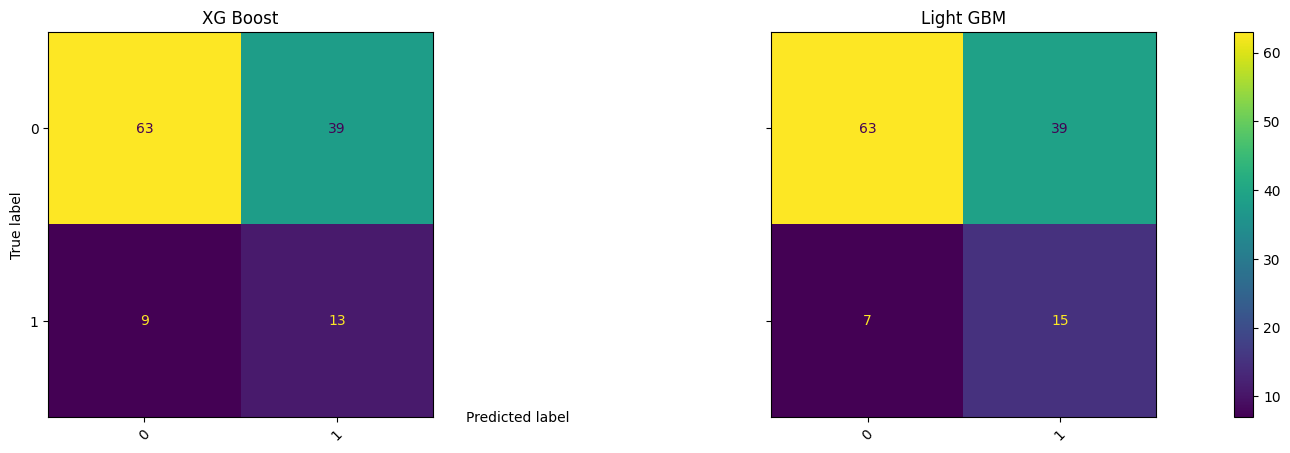

***************************************************************************************************************************


In [28]:
print('*'*38 + ' confusion matrix for the best models ' + '*'*38)
f, axes = plt.subplots(1, 2, figsize=(20, 5), sharey='row')  
labels = ['0', '1'] 
for i, (key, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm,
                                  display_labels=labels)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()
print('*'*123)

Conclusion